In [1]:
import pandas as pd
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
from functools import reduce
import matplotlib.pyplot as plt
import time
%matplotlib inline
ctx=mx.gpu(0)

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Summary

In this notebook, we consider the simplest setting of using RNNs for forecasting. We shall use our favorite time series, the [Australian beer shipment time series](https://datamarket.com/data/set/2325/four-weekly-totals-of-beer-shipments#!ds=2325&display=line) and compare the training stage of different implementations in MXNet.

* [Gluon with Recurrent Layers](https://mxnet.incubator.apache.org/api/python/gluon/rnn.html)
* [Gluon with Recurrent Cells](https://mxnet.incubator.apache.org/api/python/gluon/rnn.html)
* [Gluon Block](http://gluon.mxnet.io/chapter05_recurrent-neural-networks/rnns-gluon.html)
* [Symbolic API](https://mxnet.incubator.apache.org/api/python/symbol.html)

We found that

* Symbolic API is 5 times faster than Gluon implementations, 3s vs 25s (before hybridize) and 15s (after hybridize).
* Gluon with Recurrent Cells implementation converges much slower than others

We shall discuss the prediction stage and comparison of different structures in other notebooks.

# Load the dataset, plotting and specify params

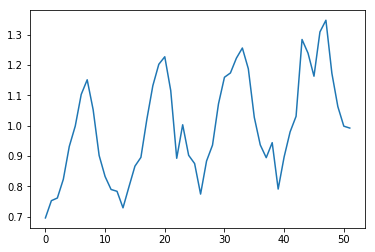

In [4]:
df = pd.read_csv("fourweekly-totals-of-beer-shipme.csv", header=0)
ts = df.values[:,1]
ts = ts/np.mean(ts)
plt.plot(ts);

In [5]:
def fourier_features(ts, N, P):
    out = np.zeros((2*N,len(ts)))
    for n in range(N):
        out[2*n,:]     = np.sin(2.0*np.pi*ts*(n+1)/P)
        out[2*n + 1,:] = np.cos(2.0*np.pi*ts*(n+1)/P)
    return out

In [6]:
T = len(ts)
xf = np.array([np.hstack([np.ones((T,1)), 
                          np.arange(T).reshape(T,1),
                          fourier_features(np.arange(T), 20, 365.25/28).T])])
yf = ts.reshape(T, 1).T
xff = nd.array(xf).as_in_context(ctx).reshape(shape=(52, 1, 42))
yff = nd.array(yf).as_in_context(ctx).reshape(shape=(52, 1, 1))

In [7]:
num_epoch = 300
num_batch = 1
num_dim = 42
hidden_dim=5
loss = gluon.loss.L2Loss()

# RNN with Gluon Recurrent Layers

In [10]:
model = mx.gluon.nn.Sequential()
with model.name_scope():
    model.add(mx.gluon.rnn.LSTM(hidden_size=hidden_dim, num_layers=1))
    model.add(mx.gluon.nn.Dense(1, flatten=False))

model.hybridize()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
trainer = gluon.Trainer(model.collect_params(), 'adam')

start_time = time.time()
for e in range(num_epoch):    
    with autograd.record():
        output = model(xff)
        L = loss(output.T, yff.T)
    L.backward()
    trainer.step(num_batch)
    if e % 100 == 0:
        print("Epoch %s. Loss: %s" % (e, np.mean(L.asnumpy())))
elapsed_time = time.time() - start_time
print("Elapsed time %s" % elapsed_time)

Epoch 0. Loss: 0.134557
Epoch 100. Loss: 0.00408704
Epoch 200. Loss: 0.00169725
Elapsed time 8.924941301345825


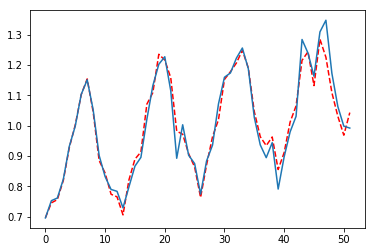

In [9]:
plt.plot(model(xff).reshape((-1,)).asnumpy(), 'r--'); plt.plot(ts);

# RNN with Gluon Recurrent Cells

In [9]:
model = mx.gluon.rnn.SequentialRNNCell()
with model.name_scope():
    model.add(mx.gluon.rnn.LSTMCell(hidden_dim))
    model.add(mx.gluon.rnn.LSTMCell(1))

model.hybridize()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
trainer = gluon.Trainer(model.collect_params(), 'adam')

start_time = time.time()
for e in range(num_epoch):
    states = model.begin_state(batch_size=num_batch)
    outputs = []    
    
    with autograd.record():
        for i in range(T):
            output, states = model(xff[i], states)
            outputs.append(output)                    
        L = loss(nd.concat(*outputs), yff.reshape((1,T)))
    
    L.backward()
    trainer.step(num_batch)
    if e % 100 == 0:
        print("Epoch %s. Loss: %s" % (e, np.mean(L.asnumpy()))) 

elapsed_time = time.time() - start_time
print("Elapsed time %s" % elapsed_time)

Epoch 0. Loss: 0.421278
Epoch 100. Loss: 0.0500686
Epoch 200. Loss: 0.0257673
Elapsed time 25.196884155273438


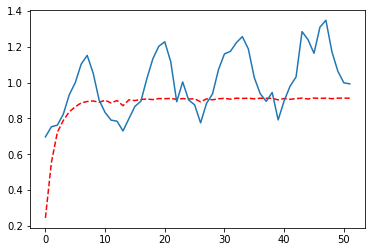

In [10]:
plt.plot(nd.concat(*outputs).reshape((-1,)).asnumpy(), 'r--')
plt.plot(ts)

# RNN with Gluon (Block)

In [20]:
class RNNModel(gluon.Block):

    def __init__(self, mode, fdim, num_hidden,
                 num_layers, tie_weights=False, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        with self.name_scope():
            if mode == 'rnn_relu':
                self.rnn = rnn.RNN(num_hidden, num_layers, activation='relu', 
                                   input_size=fdim)
            elif mode == 'rnn_tanh':
                self.rnn = rnn.RNN(num_hidden, num_layers, 
                                   input_size=fdim)
            elif mode == 'lstm':
                self.rnn = rnn.LSTM(num_hidden, num_layers, 
                                    input_size=fdim)
            elif mode == 'gru':
                self.rnn = rnn.GRU(num_hidden, num_layers, 
                                   input_size=fdim)
            else:
                raise ValueError("Invalid mode %s. Options are rnn_relu, "
                                 "rnn_tanh, lstm, and gru"%mode)
            if tie_weights:
                self.decoder = nn.Dense(1, in_units = num_hidden,
                                        params = self.encoder.params)
            else:
                self.decoder = nn.Dense(1, in_units = num_hidden)
            self.num_hidden = num_hidden

    def forward(self, inputs, hidden):
        output, hidden = self.rnn(inputs, hidden)
        decoded = self.decoder(output.reshape((-1, self.num_hidden)))
        return decoded, hidden

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

def detach(hidden):
    if isinstance(hidden, (tuple, list)):
        hidden = [i.detach() for i in hidden]
    else:
        hidden = hidden.detach()
    return hidden

In [22]:
model = RNNModel("lstm", num_dim, hidden_dim, 1)
model.hybridize()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
trainer = gluon.Trainer(model.collect_params(), 'adam')

In [23]:
start_time = time.time()

for e in range(num_epoch):
    hidden = model.begin_state(func = mx.nd.zeros, batch_size = 1, ctx = ctx)
    hidden = detach(hidden)
    with autograd.record():
        output, hidden = model(xff, hidden)
        L = loss(output.T, yff)
        L.backward()
    trainer.step(1)
    if e % 100 == 0:
        print("Epoch %s. Loss: %s" % (e, L.asscalar()))
elapsed_time = time.time() - start_time
print("Elapsed time %s" % elapsed_time)

Epoch 0. Loss: 0.722596
Epoch 100. Loss: 0.121677
Epoch 200. Loss: 0.00781594
Elapsed time 14.180601835250854


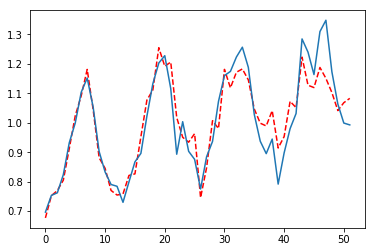

In [24]:
plt.plot(output.T.asnumpy().T, 'r--');plt.plot(ts);

# RNN with Symbolic API

In [11]:
def generate_rnn_graph(seq_len, num_hidden):        
    x = mx.sym.var('x')
    y = mx.sym.var('y')
    stack = mx.rnn.SequentialRNNCell()
    stack.add(mx.rnn.LSTMCell(num_hidden=num_hidden))

    stack.reset()
    outputs, _ = stack.unroll(seq_len, inputs=x, merge_outputs=True)
    pred = mx.sym.reshape(outputs, shape=(-1,num_hidden))
    pred = mx.sym.FullyConnected(data=pred, num_hidden=1)    
    ylabel = mx.sym.Reshape(y, shape=(-1,))
    loss = mx.sym.LinearRegressionOutput(data=pred, label=ylabel, name='regression')
    return loss, ['x'], ['y']

In [12]:
loss, data_name, label_name = generate_rnn_graph(T, hidden_dim)

In [13]:
data_iter = mx.io.NDArrayIter(data={'x': xf}, 
                             label={'y': yf})

In [14]:
mod = mx.mod.Module(loss, data_names=data_name, label_names=label_name)
mod.bind(data_shapes=data_iter.provide_data, label_shapes=data_iter.provide_label)

In [15]:
start_time = time.time()
data_iter.reset()
mod.fit(data_iter, optimizer="adam", num_epoch=num_epoch, eval_metric='mse')
elapsed_time = time.time() - start_time
print("Elapsed time %s" % elapsed_time)

Elapsed time 1.7642755508422852


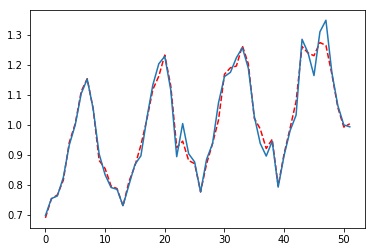

In [16]:
pred = mod.predict(data_iter).asnumpy()
plt.plot(pred.reshape(-1,), 'r--')
plt.plot(ts);